In [323]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

sns.set_style("darkgrid")

In [402]:
class BinomialTree():

    def __init__(self,S0,K,r,sigma,T,N):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.N = N #number of steps
        self.delta_t = T/N
        self.u = np.exp(sigma*np.sqrt(self.delta_t)) #CRR_u_approx
        self.d = 1/self.u #CRR_d_approx
        self.q = (np.exp(self.r*self.delta_t) - self.d)/(self.u-self.d)


    def european_price_option(self, option_type, all_tree=False):
       
        self.tree = np.zeros((self.N + 1, self.N + 1))
        
        if option_type in ("call", "put"):
            for i in range(self.N + 1):
                for j in range(i + 1):
                    self.tree[j, i] = self.S0 * (self.u ** (i - j)) * (self.d ** j)
        elif option_type == "put lookback":
            for j in range(self.N + 1):
                self.tree[j, j:] = 1 * (self.u ** (j)) 
        elif option_type == "call lookback":
            for j in range(self.N + 1):
                self.tree[j, j:] = 1 * (self.d ** (j)) 
                     
        
        option_tree = np.zeros((self.N + 1, self.N + 1))
        
        if option_type == 'call':
            option_tree[:, self.N] = np.maximum(0, self.tree[:, self.N] - self.K)
        elif option_type == 'put':
            option_tree[:, self.N] = np.maximum(0, self.K - self.tree[:, self.N])
        elif option_type == 'put lookback':
            option_tree[:, self.N] = self.tree[:, self.N] - 1
        elif option_type == 'call lookback':
            option_tree[:, self.N] = 1 - self.tree[:, self.N]

        
        if option_type in ("call", "put"):
            for i in range(self.N - 1, -1, -1):
                for j in range(i + 1):
                    option_tree[j, i] = np.exp(-self.r * self.delta_t) * (self.q * option_tree[j, i + 1] + (1 - self.q) * option_tree[j + 1, i + 1])
                    
        elif option_type == "put lookback":
            for i in range(self.N - 1, -1, -1):
                for j in range(i + 1):
                    if j == 0:
                        option_tree[j, i] = np.exp(-self.r * self.delta_t) * (self.q * self.u * option_tree[j, i + 1] + (1 - self.q) * self.d * option_tree[j + 1, i + 1])
                    else:
                        option_tree[j, i] = np.exp(-self.r * self.delta_t) * (self.q * self.u * option_tree[j - 1, i + 1] + (1 - self.q) * self.d * option_tree[j + 1, i + 1])
                        
        elif option_type == "call lookback":
            for i in range(self.N - 1, -1, -1):
                for j in range(i + 1):
                    if j == 0:
                        option_tree[j, i] = np.exp(-self.r * self.delta_t) * (self.q * self.u * option_tree[j + 1, i + 1] + (1 - self.q) * self.d * option_tree[j, i + 1])
                    else:
                        option_tree[j, i] = np.exp(-self.r * self.delta_t) * (self.q * self.u * option_tree[j + 1, i + 1] + (1 - self.q) * self.d * option_tree[j - 1, i + 1])

        
        if option_type in ("put lookback", "call lookback"):
            return option_tree[0, 0]*self.S0
        else:
            return option_tree[0, 0]
    
    def brute_force_tree(self):
                
        self.tree = [[(self.S0, self.S0, self.S0)]]  #root
        
        for step in range(1, self.N + 1):
            previous_level = self.tree[step - 1]
            current_level = []
            
            for parent_index, (parent_price, parent_min, parent_max) in enumerate(previous_level):
                up_price = parent_price * self.u
                up_min = min(parent_min, up_price)  
                up_max = max(parent_max, up_price) 
                current_level.append((up_price, up_min, up_max))
                
                down_price = parent_price * self.d
                down_min = min(parent_min, down_price) 
                down_max = max(parent_max, down_price)
                current_level.append((down_price, down_min, down_max))
            
            self.tree.append(current_level)
            
    def price_lookback_option(self, option_type):
            
            if not self.tree:
                raise ValueError("Tree has not been build yet")

            # Krok 1: Oblicz payoff na ostatnim poziomie drzewa
            option_values = []
            for price, min_price, max_price in self.tree[-1]:
                if option_type == "call lookback":
                    payoff = max(price - min_price, 0)  # Lookback call payoff
                elif option_type == "put lookback":
                    payoff = max(max_price - price, 0)  # Lookback put payoff
                option_values.append(payoff)
            
           
            for step in range(self.N - 1, -1, -1):  
                next_level = option_values  
                option_values = []
                
                for i in range(len(self.tree[step])):
                    
                    up_value = next_level[2 * i]      
                    down_value = next_level[2 * i + 1]  
                    discounted_value = np.exp(-self.r * self.delta_t) * (self.q * up_value + (1 - self.q) * down_value)
                    option_values.append(discounted_value)
            
            # Wartość opcji w korzeniu drzewa
            return option_values[0]

    
    def display_tree(self):
        
        if self.tree is None:
            print("Tree has not been build")
            return
        
        for step, row in enumerate(self.tree):
            print(f"Step {step}:")
            for node in row:
                print(f"  Price: {node[0]:.2f}, Min: {node[1]:.2f}, Max: {node[2]:.2f}")
            print()
        
        

def binomial_pricing_N(S0,K,r,sigma,T,Nmax, option_type):
    ranging = range(5,Nmax +1,1)
    price_N = np.zeros(len(ranging))

    for i, N in enumerate(ranging):
        binomTree = BinomialTree(S0,K,r,sigma,T,N)
        price_N[i] = binomTree.european_price_option(option_type)
    return price_N

def binomial_bruteforce_pricing_N(S0,K,r,sigma,T,Nmax, option_type):
    ranging = range(5,Nmax +1,1)
    price_N = np.zeros(len(ranging))

    for i, N in enumerate(ranging):
        binomTree = BinomialTree(S0,K,r,sigma,T,N)
        binomTree.brute_force_tree()
        price_N[i] = binomTree.price_lookback_option(option_type)
        
    return price_N

def call_price(S, K, T, r, sigma, t=0):
    N = ss.norm.cdf
    d1 = (np.log(S/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt((T - t))
    return S * N(d1) - K * np.exp(-r*(T-t))* N(d2)

def put_price(S, K, T, r, sigma, t=0):
    N = ss.norm.cdf
    d1 = (np.log(S/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma* np.sqrt((T-t))
    return K*np.exp(-r*(T-t))*N(-d2) - S*N(-d1)

def lookback_call(S, M, T, r, sigma, D, t=0):
    N = ss.norm.cdf
    sqrt_term = np.sqrt(T - t)
    d1 = (np.log(S/M) + (r - D + 0.5 * sigma**2) * (T - t)) / (sigma * sqrt_term)
    d2 = d1 - sigma * sqrt_term
    
    term1 = S * np.exp(-D * (T - t)) * N(d1)
    term2 = M * np.exp(-r * (T - t)) * N(d2)
    term3 = (sigma**2 / (2 * (r - D))) * S * np.exp(-r * (T - t)) * (
        (S/M)**(2*(D-r)/(sigma**2))* N(-d1 + 2 * (r - D) * sqrt_term / sigma) - np.exp((r - D) * (T - t)) * N(-d1)
    )
    
    return term1 - term2 + term3

def lookback_put(S, M, T, r, sigma, D, t=0):
    N = ss.norm.cdf
    sqrt_term = np.sqrt(T - t)
    d1 = (np.log(S/M) + (r - D + 0.5 * sigma**2) * (T - t)) / (sigma * sqrt_term)
    d2 = d1 - sigma * sqrt_term
    
    term1 = M * np.exp(-r * (T - t)) * N(-d2)
    term2 = S * np.exp(-D * (T - t)) * N(-d1)
    term3 = (sigma**2 / (2 * (r - D))) * S * np.exp(-r * (T - t)) * (
        -(S/M)**(2*(D-r)/sigma**2) * N(d1 - 2 * (r - D) * sqrt_term / sigma) + np.exp((r - D) * (T - t)) * N(d1)
    )
    
    return term1 - term2 + term3

class GBM():
    
    def __init__(self, sigma, mu, S0, T=2, dt=0.01):
        
        self.sigma = sigma
        self.mu = mu
        self.S0 = S0
        self.T = T
        self.dt = dt 
        
        norm = ss.norm.rvs(0, np.sqrt(dt), size = int(round(T/dt))) 
        Wt = np.cumsum(norm) #brownian motion
        
        self.trajectory = np.concatenate([np.array([self.S0]), self.S0*np.exp((mu-(self.sigma**2)/2)*np.arange(dt, T, step=dt) + self.sigma*Wt[:-1])])
                
    def plot(self):
        
        plt.plot(np.arange(self.T, step = self.dt), self.trajectory)
        plt.xlabel("t")
        plt.ylabel("S(t)")
        plt.show()
        



In [403]:
S0=100
r=0.05
sigma=0.02
T=0.5
Nmax=500

In [331]:
MC_steps = 100000
min_vec = np.zeros(MC_steps)
max_vec = np.zeros(MC_steps)
call_value = np.zeros(MC_steps)
put_value = np.zeros(MC_steps)
for MC in np.arange(MC_steps):
    gbm = GBM(sigma=sigma, mu=r, S0=S0, T=0.5, dt=0.001)
    min_vec[MC] = np.min(gbm.trajectory)
    call_value[MC] = (gbm.trajectory[-1] - min_vec[MC])*np.exp(-r*T)
    max_vec[MC] = np.max(gbm.trajectory)
    put_value[MC] = (max_vec[MC] - gbm.trajectory[-1])*np.exp(-r*T)
avg_min = np.mean(min_vec)
avg_max = np.mean(max_vec)

In [343]:
put_price_fixed = lookback_put(S0, S0, T, r, sigma, D=0, t=0)
call_price_fixed = lookback_call(S0, S0, T, r, sigma, D=0, t=0)

put_price_mc_max = lookback_put(S0, avg_max, T, r, sigma, D=0, t=0)
call_price_mc_min = lookback_call(S0, avg_min, T, r, sigma, D=0, t=0)

put_price_mc = np.mean(put_value)
call_price_mc = np.mean(call_value)


In [404]:
call_lookback_price_normal = binomial_pricing_N(S0=100,K=None,r=0.05,sigma=0.02,T=0.5,Nmax=500, option_type='call lookback')
call_lookback_price_bruteforce = binomial_bruteforce_pricing_N(S0=100,K=None,r=0.05,sigma=0.02,T=0.5,Nmax=20, option_type='call lookback')

In [387]:
put_lookback_price_normal = binomial_pricing_N(S0=100,K=None,r=0.05,sigma=0.02,T=0.5,Nmax=500, option_type='put lookback')
put_lookback_price_bruteforce = binomial_bruteforce_pricing_N(S0=100,K=None,r=0.05,sigma=0.02,T=0.5,Nmax=20, option_type='put lookback')

In [389]:
len(call_lookback_price_normal)

496

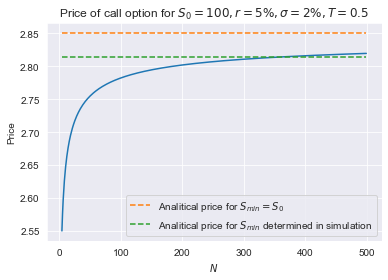

In [405]:
plt.plot(np.arange(4, 500), call_lookback_price_normal)
plt.plot(np.arange(4, 500), [call_price_fixed for _ in np.arange(496)], linestyle="--", label="Analitical price for $S_{min} = S_0$")
plt.plot(np.arange(4, 500), [call_price_mc for _ in np.arange(496)], linestyle="--", label="Analitical price for $S_{min}$ determined in simulation")
plt.xlabel("$N$")
plt.ylabel("Price")
plt.title('Price of call option for $S_0 = 100, r = 5\%, \sigma = 2\%, T = 0.5$')
plt.legend()

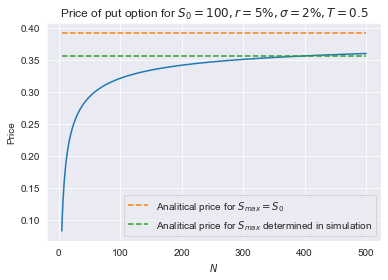

In [406]:
plt.plot(np.arange(5, 501), put_lookback_price_normal)
plt.plot(np.arange(5, 501), [put_price_fixed for _ in np.arange(496)], linestyle="--", label="Analitical price for $S_{max} = S_0$")
plt.plot(np.arange(5, 501), [put_price_mc for _ in np.arange(496)], linestyle="--", label="Analitical price for $S_{max}$ determined in simulation")
plt.xlabel("$N$")
plt.ylabel("Price")
plt.title('Price of put option for $S_0 = 100, r = 5\%, \sigma = 2\%, T = 0.5$')
plt.legend()

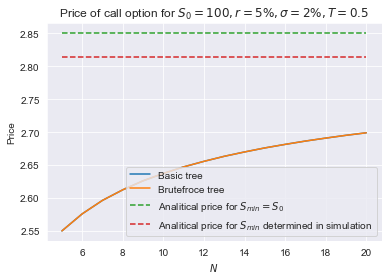

In [407]:
plt.plot(np.arange(5, 21), call_lookback_price_normal[:21-5], label="Basic tree")
plt.plot(np.arange(5, 21), call_lookback_price_bruteforce, label="Brutefroce tree")
plt.plot(np.arange(5, 21), [call_price_fixed for _ in np.arange(16)], linestyle="--", label="Analitical price for $S_{min} = S_0$")
plt.plot(np.arange(5, 21), [call_price_mc for _ in np.arange(16)], linestyle="--", label="Analitical price for $S_{min}$ determined in simulation")
plt.xlabel("$N$")
plt.ylabel("Price")
plt.title('Price of call option for $S_0 = 100, r = 5\%, \sigma = 2\%, T = 0.5$')
plt.legend()

In [409]:
put_lookback_price_bruteforce

array([0.08260011, 0.10911021, 0.13004811, 0.14649416, 0.1604776 ,
       0.17197219, 0.18216101, 0.19078667, 0.19863717, 0.20542336,
       0.21171267, 0.21723512, 0.22242086, 0.22703035, 0.2314019 ,
       0.23532617])

In [410]:
put_lookback_price_normal[:21-5]

array([0.08260011, 0.10911021, 0.13004811, 0.14649416, 0.1604776 ,
       0.17197219, 0.18216101, 0.19078667, 0.19863717, 0.20542336,
       0.21171267, 0.21723512, 0.22242086, 0.22703035, 0.2314019 ,
       0.23532617])

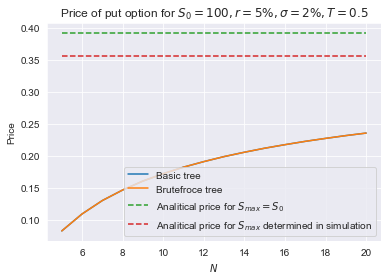

In [408]:
plt.plot(np.arange(5, 21), put_lookback_price_normal[:21-5], label="Basic tree")
plt.plot(np.arange(5, 21), put_lookback_price_bruteforce, label="Brutefroce tree")
plt.plot(np.arange(5, 21), [put_price_fixed for _ in np.arange(16)], linestyle="--", label="Analitical price for $S_{max} = S_0$")
plt.plot(np.arange(5, 21), [put_price_mc for _ in np.arange(16)], linestyle="--", label="Analitical price for $S_{max}$ determined in simulation")
plt.xlabel("$N$")
plt.ylabel("Price")
plt.title('Price of put option for $S_0 = 100, r = 5\%, \sigma = 2\%, T = 0.5$')
plt.legend()